In [ ]:
# install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
print(tf.__version__)

2.6.0


### Create a fashion-MNIST dataset

In [ ]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [ ]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4431872/4422102 [==============================] - 0s 0us/step


### Define the network

In [ ]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

In [ ]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

### Create Model

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train the model

In [ ]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 0 | disc_loss: 0.7409862875938416 | gen_loss: 1.3565258979797363


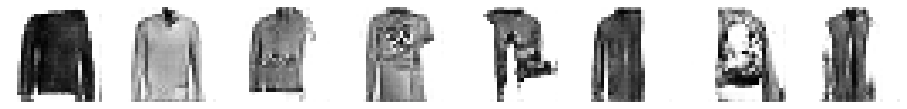

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1 | disc_loss: 0.7946659922599792 | gen_loss: 1.531572937965393


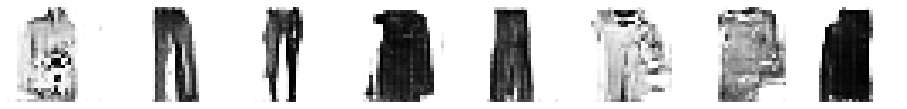

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2 | disc_loss: 0.8216210007667542 | gen_loss: 1.4712724685668945


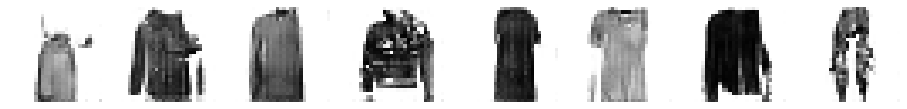

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3 | disc_loss: 0.7664272785186768 | gen_loss: 1.672903060913086


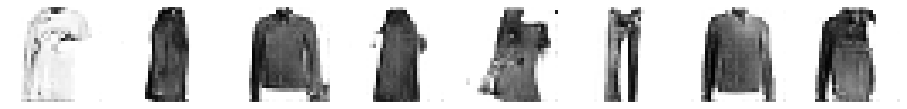

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4 | disc_loss: 0.8398314118385315 | gen_loss: 2.114377975463867


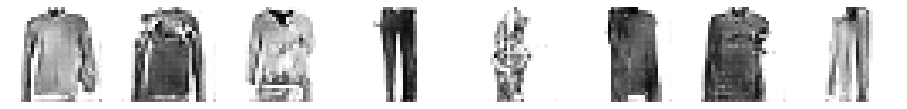

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5 | disc_loss: 0.8723762631416321 | gen_loss: 1.2862218618392944


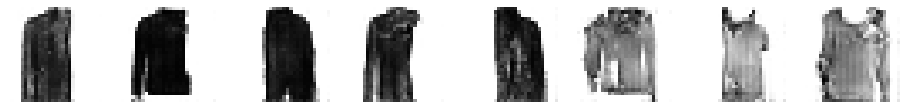

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6 | disc_loss: 0.8717823028564453 | gen_loss: 1.903664469718933


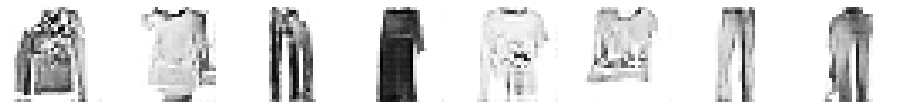

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7 | disc_loss: 0.7491756677627563 | gen_loss: 1.5025609731674194


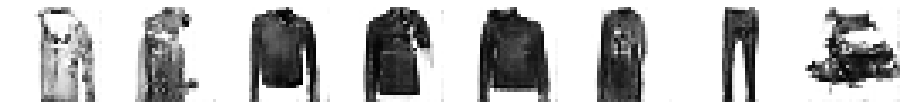

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8 | disc_loss: 0.8344514966011047 | gen_loss: 1.3164561986923218


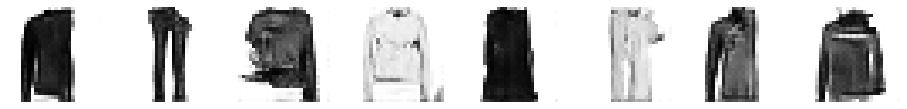

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9 | disc_loss: 0.6803889870643616 | gen_loss: 1.3209148645401


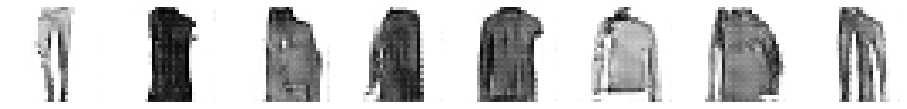

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10 | disc_loss: 0.8448458313941956 | gen_loss: 1.975544810295105


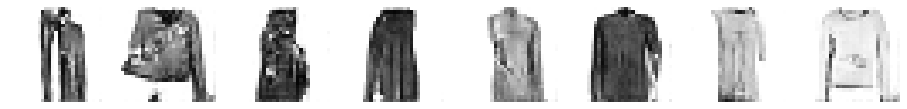

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11 | disc_loss: 0.8556298613548279 | gen_loss: 1.8661434650421143


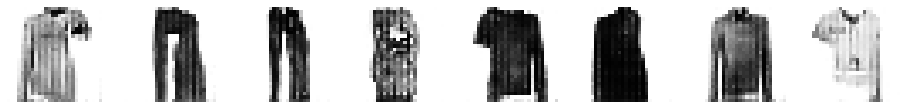

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12 | disc_loss: 0.7904233932495117 | gen_loss: 1.4643992185592651


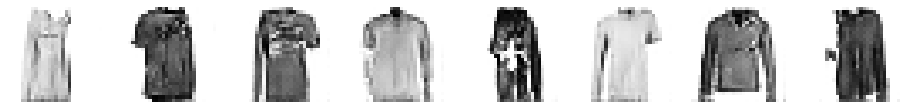

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13 | disc_loss: 0.8798591494560242 | gen_loss: 1.987418532371521


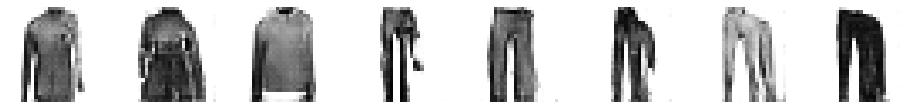

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14 | disc_loss: 0.8705366849899292 | gen_loss: 1.8422142267227173


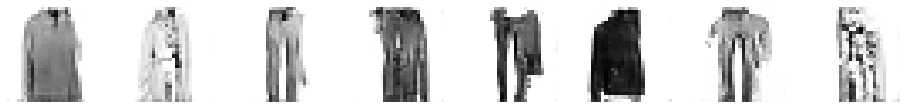

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15 | disc_loss: 0.7717607021331787 | gen_loss: 1.3967618942260742


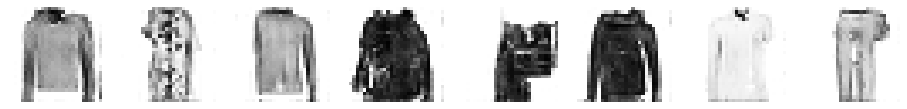

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16 | disc_loss: 0.7899799942970276 | gen_loss: 1.4974441528320312


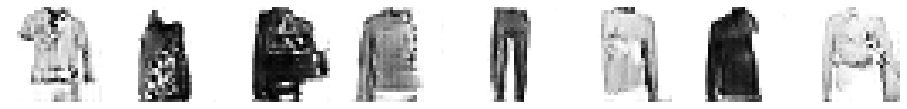

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17 | disc_loss: 0.8468983173370361 | gen_loss: 1.2316592931747437


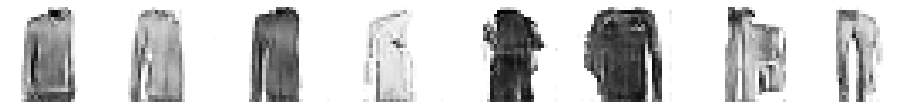

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18 | disc_loss: 0.7849182486534119 | gen_loss: 1.4655414819717407


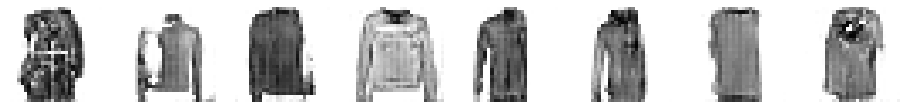

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19 | disc_loss: 0.8224390149116516 | gen_loss: 1.4678676128387451


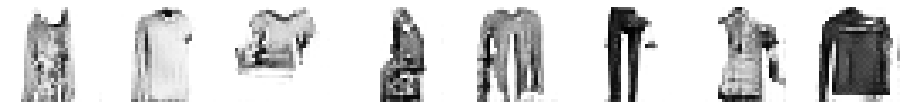

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20 | disc_loss: 0.7876198291778564 | gen_loss: 1.5781943798065186


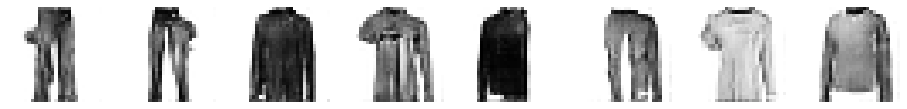

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 21 | disc_loss: 0.9341826438903809 | gen_loss: 1.9410051107406616


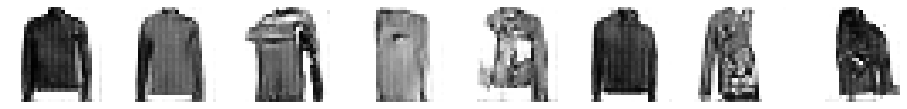

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 22 | disc_loss: 0.8428563475608826 | gen_loss: 1.662827730178833


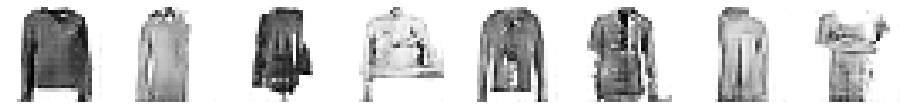

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 23 | disc_loss: 0.8151524662971497 | gen_loss: 1.5346193313598633


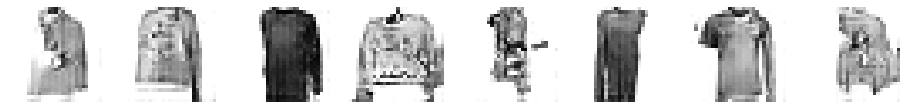

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 24 | disc_loss: 0.7789061665534973 | gen_loss: 1.5150136947631836


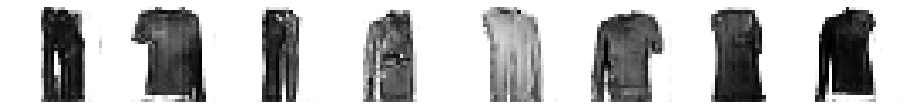

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 25 | disc_loss: 0.7785496115684509 | gen_loss: 1.7407159805297852


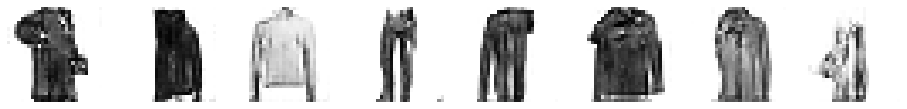

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 26 | disc_loss: 0.834031343460083 | gen_loss: 1.610787272453308


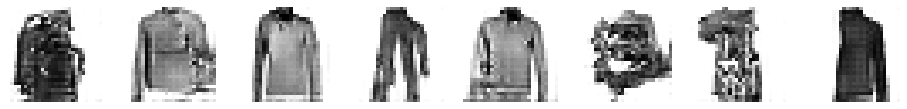

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 27 | disc_loss: 0.8017194271087646 | gen_loss: 1.8449817895889282


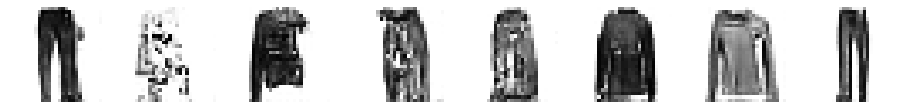

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 28 | disc_loss: 0.7677013278007507 | gen_loss: 1.6339137554168701


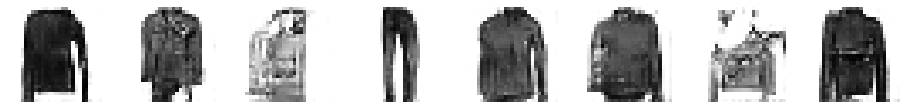

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 29 | disc_loss: 0.8775169253349304 | gen_loss: 1.9727176427841187


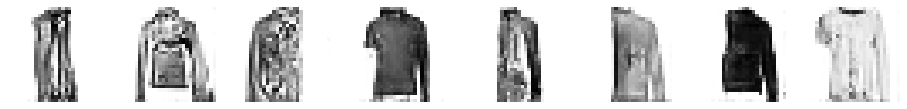

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 30 | disc_loss: 0.8584663271903992 | gen_loss: 1.9659734964370728


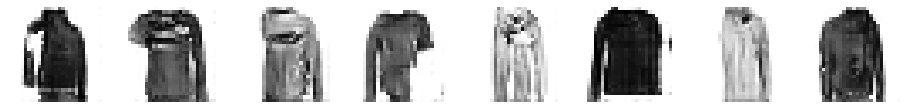

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 31 | disc_loss: 0.8025307655334473 | gen_loss: 1.7151250839233398


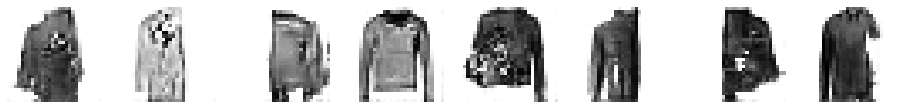

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 32 | disc_loss: 0.8247597813606262 | gen_loss: 1.3806498050689697


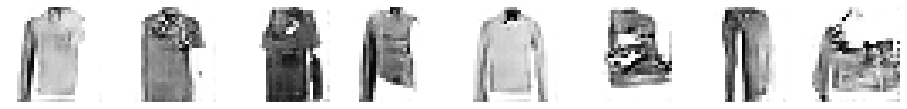

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 33 | disc_loss: 0.9796481132507324 | gen_loss: 2.216813325881958


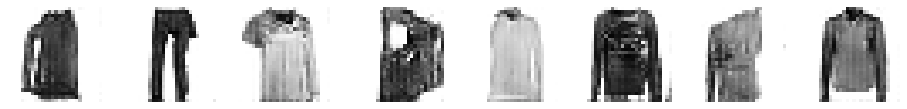

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 34 | disc_loss: 0.8048958778381348 | gen_loss: 1.4303970336914062


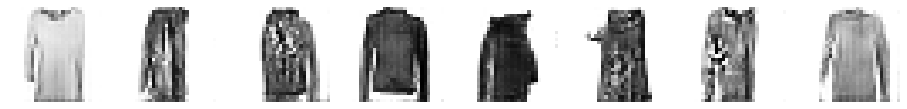

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 35 | disc_loss: 0.7500327229499817 | gen_loss: 1.7308244705200195


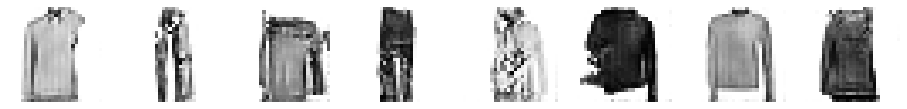

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 36 | disc_loss: 0.8436844348907471 | gen_loss: 1.4400805234909058


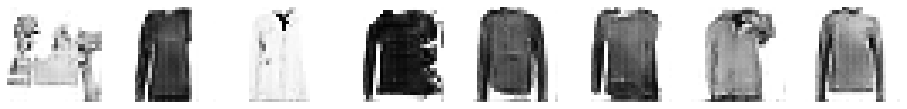

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 37 | disc_loss: 0.8735633492469788 | gen_loss: 2.179485559463501


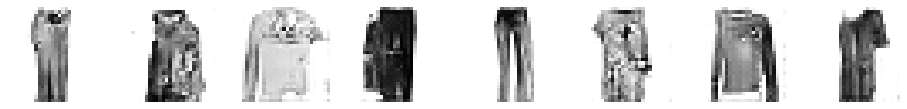

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 38 | disc_loss: 0.8531963229179382 | gen_loss: 1.244275689125061


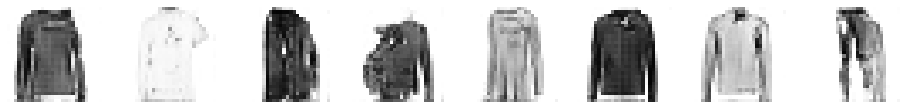

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 39 | disc_loss: 0.8938790559768677 | gen_loss: 1.8070389032363892


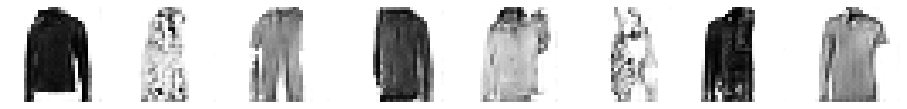

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 40 | disc_loss: 0.9535437226295471 | gen_loss: 1.9658994674682617


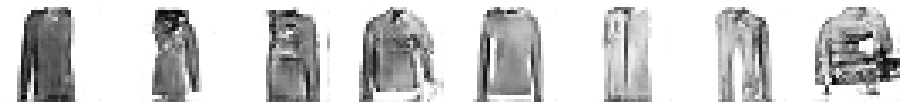

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 41 | disc_loss: 1.0077553987503052 | gen_loss: 0.9923657774925232


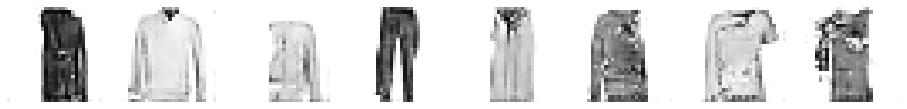

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 42 | disc_loss: 0.8677205443382263 | gen_loss: 1.5185225009918213


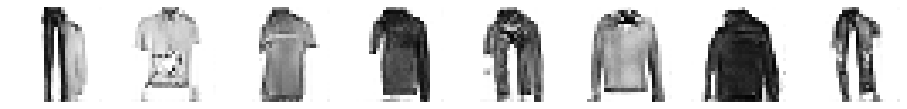

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 43 | disc_loss: 0.8061391711235046 | gen_loss: 1.3668293952941895


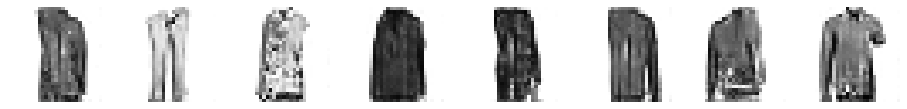

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 44 | disc_loss: 0.8231292963027954 | gen_loss: 1.3566135168075562


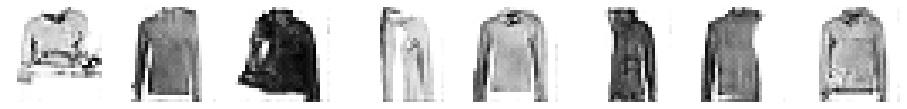

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 45 | disc_loss: 0.7455739378929138 | gen_loss: 1.672810673713684


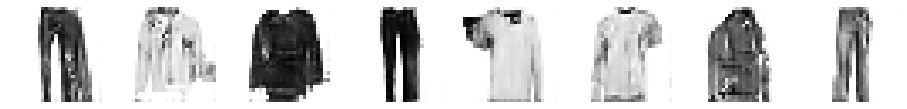

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 46 | disc_loss: 1.0326378345489502 | gen_loss: 0.9618968963623047


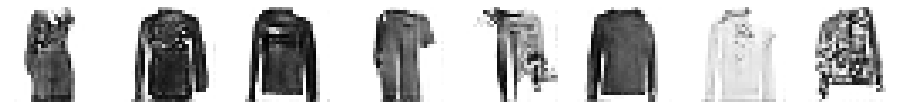

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 47 | disc_loss: 0.8030385971069336 | gen_loss: 1.352434754371643


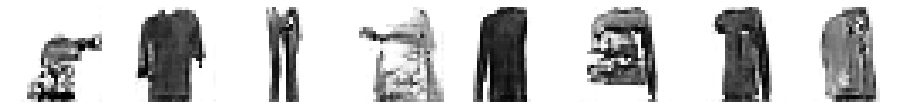

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 48 | disc_loss: 0.8659461140632629 | gen_loss: 1.1950018405914307


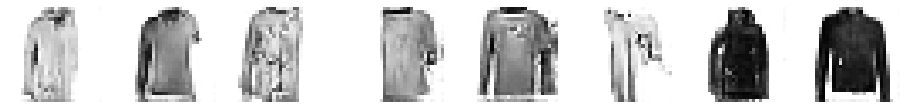

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 49 | disc_loss: 0.9207975268363953 | gen_loss: 1.0951906442642212


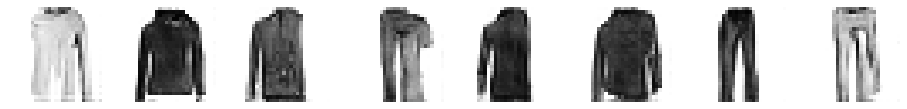

In [ ]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    # display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)